# Data Analysis
This Notebook contains a few data analysis examples of the result data from the ETL process.

The data model is shown below as a reference to help making the appropriate queries.

![Data model](assets/datamodel.png)

Try it out and see what kind of insights you find from the data!

In [136]:
import os
import glob
import psycopg2
import pandas as pd
from sql_queries import *

In [137]:
conn = psycopg2.connect("host=127.0.0.1 dbname=sparkifydb user=student password=student")
conn.set_session(autocommit=True)
cur = conn.cursor()

## Top lists

### 10 most played songs

In [138]:
query = """
SELECT songs.title AS Song, artists.name AS Artist, COUNT(songs.title) AS "Play count"
FROM
    songplays
INNER JOIN songs ON songplays.song_id = songs.song_id
INNER JOIN artists ON songplays.artist_id = artists.artist_id
GROUP BY songs.title, artists.name
ORDER BY COUNT(songs.title) DESC
LIMIT 10
"""
cur.execute(query)
row = cur.fetchone()
while row:
   print(row)
   row = cur.fetchone()

('Setanta matins', 'Elena', 1)


**NOTE**
Since this is a subset of the much larger dataset, the solution dataset will only have 1 row with values for value containing ID for both songid and artistid in the fact table. Those are the only 2 values that the query in the sql_queries.py will return that are not-NONE. The rest of the rows will have NONE values for those two variables.

### 10 longest songs

In [139]:
query = """
SELECT songs.title AS Song, artists.name AS Artist, songs.duration
FROM
    songs
INNER JOIN artists ON songs.artist_id = artists.artist_id
ORDER BY songs.duration DESC
LIMIT 10
"""
cur.execute(query)
row = cur.fetchone()
while row:
   print(row)
   row = cur.fetchone()

('Sohna Nee Sohna Data', 'Faiz Ali Faiz', 599.24853)
('Sono andati? Fingevo di dormire', 'Montserrat Caballé;Placido Domingo;Vicente Sardinero;Judith Blegen;Sherrill Milnes;Georg Solti', 511.16363)
('Floating', 'Blue Rodeo', 491.12771)
('The Emperor Falls', 'John Wesley', 484.62322)
('Salt In NYC', 'Trafik', 424.12363)
('Kutt Free (DJ Volume Remix)', 'Jinx', 407.37914)
('Prognosis', 'Steve Morse', 363.85914)
('Do You Finally Need A Friend', 'Terry Callier', 342.56934)
('Superconfidential', 'Clp', 338.31138)
('Got My Mojo Workin', 'Pucho & His Latin Soul Brothers', 338.23302)


### 10 most active listeners

In [140]:
query = """
SELECT users.first_name AS Firstname, users.last_name AS Lastname, COUNT(songplays.songplay_id) AS Playcount
FROM
    songplays
INNER JOIN users ON songplays.user_id = users.user_id
GROUP BY Firstname, Lastname
ORDER BY COUNT(songplays.songplay_id) DESC
LIMIT 10
"""
cur.execute(query)
row = cur.fetchone()
while row:
   print(row)
   row = cur.fetchone()

('Chloe', 'Cuevas', 689)
('Tegan', 'Levine', 665)
('Kate', 'Harrell', 557)
('Lily', 'Koch', 463)
('Aleena', 'Kirby', 397)
('Jacqueline', 'Lynch', 346)
('Layla', 'Griffin', 321)
('Jacob', 'Klein', 289)
('Mohammad', 'Rodriguez', 270)
('Matthew', 'Jones', 248)


## Alternative querying methods
It is possible to read SQL queries directly into a Pandas DataFrame, which makes further filtering, analysis and visualization of data easy and efficient.

Below is a simple example to get you started.

### Play count over time
We have time dimension table that can be utilized for grouping/aggregating data by calendar. However, modern BI/analytical tools have great support for handling dates and times. Thus for this example I will just read the timestamps from the database and instead rely on the built-in funtions from Pandas to make this timeseries analysis.

Read a maximum 1000 log rows to the dataframe.

In [141]:
query = """
SELECT songplay_id AS id, start_time AS timestamp
FROM
    songplays
ORDER BY start_time DESC
LIMIT 1000
"""
df = pd.read_sql_query(query, conn)
df.head()

,id,timestamp
0,1277,1543607664796
1,1276,1543603884796
2,1275,1543603678796
3,1274,1543603476796
4,1273,1543603205796


Parse the timestamp value into a date time object.

In [142]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
df.head()

,id,timestamp,datetime
0,1277,1543607664796,2018-11-30 19:54:24.796
1,1276,1543603884796,2018-11-30 18:51:24.796
2,1275,1543603678796,2018-11-30 18:47:58.796
3,1274,1543603476796,2018-11-30 18:44:36.796
4,1273,1543603205796,2018-11-30 18:40:05.796


Let's see the daily play counts.

In [143]:
df.groupby(by=pd.Grouper(key='datetime', freq='24h')).count()

,id,timestamp
datetime,,
2018-11-28,351,351
2018-11-29,319,319
2018-11-30,330,330


Let's try to increase the granularity to hourly play count and instead plot the result.

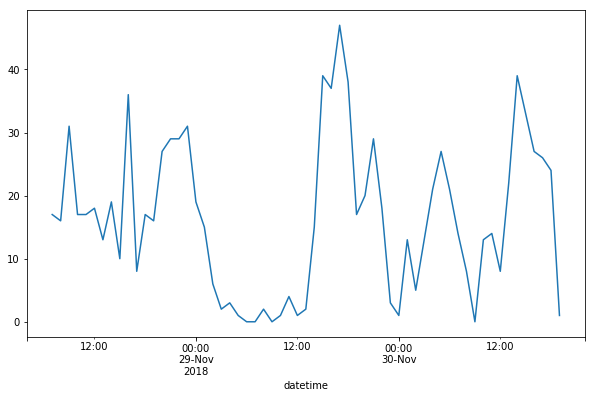

In [144]:
df.groupby(by=pd.Grouper(key='datetime', freq='1h')).count()['id'].plot(figsize=(10,6))

You can also do data aggregation using SQL queries if you prefer that. 

In [149]:
query = """
SELECT 
    TO_CHAR(MAKE_TIMESTAMP(time.year, time.month, time.day, time.hour, 0, 0), 'YYYY-MM-DD HH24:MI') AS datetime,
    COUNT(songplay_id) AS playcount
FROM 
    songplays
INNER JOIN 
    time ON songplays.start_time = time.start_time 
GROUP BY 
    time.year, time.month, time.day, time.hour, datetime
ORDER BY 
    time.year DESC, time.month DESC, time.day DESC, time.hour DESC
LIMIT 57
"""
df = pd.read_sql_query(query, conn, parse_dates=['datetime'])
df.head()

,datetime,playcount
0,2018-11-30 19:00:00,1
1,2018-11-30 18:00:00,24
2,2018-11-30 17:00:00,26
3,2018-11-30 16:00:00,27
4,2018-11-30 15:00:00,33


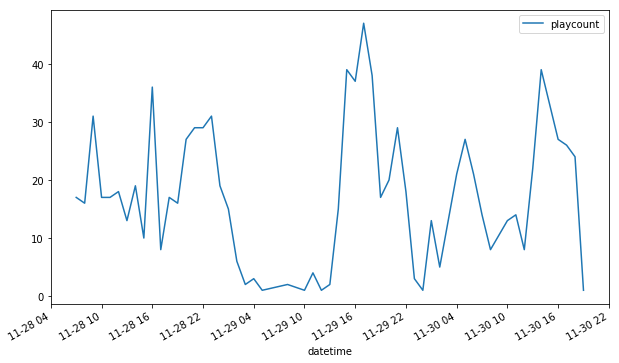

In [150]:
df.plot(x='datetime', y='playcount', figsize=(10,6))

### Close connection

In [135]:
conn.close()